# Tweets

For first run in jupyter run next comand:
!pip install pandas nltk sklearn matplotlib gensim

In [18]:
!python3 -m pip install pandas nltk sklearn matplotlib gensim

!which python3
!python --version

     |████████████████████████████████| 55.3 MB 96 kB/s /s eta 0:00:01
/Users/rcotter-/.brew/bin/python3
Python 2.7.16


In [6]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('stopwords')

from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marina.romashkova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data preparation

### Make dataframe


In [7]:
df_neg = pd.read_csv("./data/processedNegative.csv", header=None, sep=",")
df_neg = df_neg.T.rename(columns={0:'tweet'})
df_neg['tone'] = "negative"

In [8]:
df_neg.head()

,tweet,tone
0,How unhappy some dogs like it though,negative
1,talking to my over driver about where I'm goin...,negative
2,Does anybody know if the Rand's likely to fall...,negative
3,I miss going to gigs in Liverpool unhappy,negative
4,There isnt a new Riverdale tonight ? unhappy,negative


In [9]:
df_pos = pd.read_csv("./data/processedPositive.csv", header=None, sep=",")
df_pos = df_pos.T.rename(columns={0:'tweet'})
df_pos['tone'] = "positive"



In [10]:
df_pos.head()

,tweet,tone
0,An inspiration in all aspects: Fashion,positive
1,fitness,positive
2,beauty and personality. :)KISSES TheFashionIcon,positive
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,positive
4,Beautiful album from the greatest unsung guit...,positive


In [11]:
df_neut = pd.read_csv("./data/processedNeutral.csv", header=None)
df_neut = df_neut.T.rename(columns={0:'tweet'})
df_neut['tone'] = "neutral"

In [12]:
df_neut.head()

,tweet,tone
0,Pak PM survives removal scare,neutral
1,but court orders further probe into corruptio...,neutral
2,Supreme Court quashes criminal complaint again...,neutral
3,Art of Living's fights back over Yamuna floodp...,neutral
4,livid.,neutral


In [13]:
df = pd.concat([df_neg, df_pos, df_neut], ignore_index=True)

In [14]:
df

,tweet,tone
0,How unhappy some dogs like it though,negative
1,talking to my over driver about where I'm goin...,negative
2,Does anybody know if the Rand's likely to fall...,negative
3,I miss going to gigs in Liverpool unhappy,negative
4,There isnt a new Riverdale tonight ? unhappy,negative
...,...,...
3868,IDFC official Vikram Limaye,neutral
3869,former captain Diana Edulji are others in pan...,neutral
3870,Supreme Court names former CAG as head of 4-me...,neutral
3871,Court summons CM suspended BJP MP as accused i...,neutral


<AxesSubplot:>

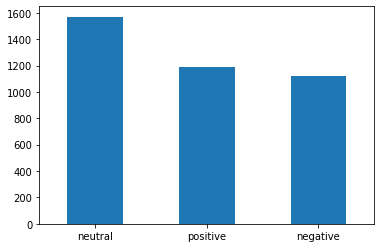

In [15]:
df['tone'].value_counts().plot(kind="bar", rot=0)

## Preprocessing

tokenization - split tweets into words

In [16]:
df['tokenization'] = df.apply(lambda row: nltk.word_tokenize(str(row['tweet']).lower()), axis=1)

In [17]:
df

,tweet,tone,tokenization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u..."
...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a..."



stemming - finding the stem of a word

In [34]:
stemmer = nltk.stem.SnowballStemmer(language="english")
df['stemming'] = df['tokenization'].apply(lambda x: [stemmer.stem(y) for y in x])
df

,tweet,tone,tokenization,stemming
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un..."
...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu..."


In [35]:
stemmer_ = nltk.stem.PorterStemmer()
df['stemming+'] = df['tokenization'].apply(lambda x: [stemmer_.stem(y) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un..."
...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu..."



lemmatization - finding the root of a word

In [36]:
lemmatizer = nltk.stem.WordNetLemmatizer()
df['lemmatization'] = df['tokenization'].apply(lambda x: [lemmatizer.lemmatize(str(y)) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u..."
...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac..."


misspealing - correct possible misspealings

In [42]:
correct_words = words.words()

def misspealings(word):
  temp = [(jaccard_distance(set(ngrams(word, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==word[0]]
  return sorted(temp, key = lambda val:val[0])[0][1]

sample_word = "amzing"
print(f'The word "{sample_word}" is a misspealing of word - "{misspealings(sample_word)}"')

The word "amzing" is a misspealing of word - "amazing"


In [43]:
def check_misspeal(word):
    if len(word) > 2 and "'" not in word and "." not in word and word.isalpha():
        return misspealings(word)
    return word
    

In [44]:
df['misspealings'] = df['tokenization'].apply(lambda x: [check_misspeal(str(y)) for y in x])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u..."
...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac..."


In [ ]:
df['misspealings+lemma'] = df['lemmatization'].apply(lambda x: [check_misspeal(str(y)) for y in x])
df

Filtering tweets

In [41]:
stop_words = set(stopwords.words('english'))
example_sent = """This is a sample sentence,
                  showing off the stop words filtration."""
word_tokens = word_tokenize(example_sent)
 
filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]

print(f'The sentence "{example_sent}" was filtered:\n "{filtered_sentence}"')

This is a sample sentence,
                  showing off the stop words filtration.
['sample', 'sentence', ',', 'showing', 'stop', 'words', 'filtration', '.']


In [25]:
df['filtered+tokenization'] = df['tokenization'].apply(lambda x: [y for y in x if not y.lower() in stop_words])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,filtered+tokenization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[unhappy, dogs, like, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, driver, 'm, goinghe, said, 'd, love,..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[anybody, know, rand, 's, likely, fall, dollar..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[miss, going, gigs, liverpool, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[isnt, new, riverdale, tonight, ?, unhappy]"
...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[idfc, official, vikram, limaye]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, others, panel..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, names, former, cag, head, 4-m..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[court, summons, cm, suspended, bjp, mp, accus..."


In [44]:
df['misspealings+lemma+filtered'] = df['misspealings+lemma'].apply(lambda x: [y for y in x if not y.lower() in stop_words])
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,misspealings,misspealings+lemma,filtered+tokenization,misspealings+lemma+filtered
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[how, unhappy, some, dogs, like, though]","[how, unhappy, some, dog, like, though]","[unhappy, dogs, like, though]","[unhappy, dog, like, though]"
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[talking, over, driver, about, where, going, s...","[talking, over, driver, about, where, going, s...","[talking, driver, 'm, goinghe, said, 'd, love,...","[talking, driver, going, said, love, new, york..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[does, anybody, know, the, rand, likely, fall,...","[doe, anybody, know, the, rand, likely, fall, ...","[anybody, know, rand, 's, likely, fall, dollar...","[doe, anybody, know, rand, likely, fall, dolla..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[miss, going, gig, liver, unhappy]","[miss, going, gig, liver, unhappy]","[miss, going, gigs, liverpool, unhappy]","[miss, going, gig, liver, unhappy]"
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[there, is, new, riverdamp, tonight, unhappy]","[there, is, new, riverdamp, tonight, unhappy]","[isnt, new, riverdale, tonight, ?, unhappy]","[new, riverdamp, tonight, unhappy]"
...,...,...,...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]","[id, official, viagram, liman]","[idfc, official, vikram, limaye]","[id, official, viagram, liman]"
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[former, captain, dian, educe, are, other, pan...","[former, captain, dian, educe, are, other, pan...","[former, captain, diana, edulji, others, panel...","[former, captain, dian, educe, panel, run]"
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[supreme, court, name, former, cag, head, pane...","[supreme, court, name, former, cag, head, pane...","[supreme, court, names, former, cag, head, 4-m...","[supreme, court, name, former, cag, head, pane..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[court, summons, suspended, bobjerom, accused,...","[court, summons, suspended, bobjerom, accused,.

## Encoding

### OneHotEncoder


In [50]:
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform((df[['tweet']]).astype('str'))
df['ohe_tweet'] = list(X_ohe)
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,ohe_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[idfc, offici, vikram, limay]","[idfc, offici, vikram, limay]","[idfc, official, vikram, limaye]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, other, i...","[former, captain, diana, edulji, are, others, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[suprem, court, name, former, cag, as, head, o...","[suprem, court, name, former, cag, as, head, o...","[supreme, court, name, former, cag, a, head, o...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summon, cm, suspend, bjp, mp, as, accu...","[court, summons, cm, suspended, bjp, mp, a, ac...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [55]:
preprocessing_ways = [
    "tokenization",
#     "stemming",
#     "stemming+",
#     "lemmatization",
#     "misspealings",
#     "misspealings+lemma",
#     "filtered+tokenization",
#     "misspealings+lemma+filtered"
]

In [61]:
for way in preprocessing_ways:
    X_ohe = ohe.fit_transform((df[[way]]).astype('str'))
    df['ohe_' + way] = list(X_ohe)
df    

,tweet,tone,tokenization,stemming,stemming+,lemmatization,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered,wc_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.

### WordCounts
Convert a collection of text documents to a matrix of token counts.

In [59]:
vectorizer_wc = CountVectorizer()
X_wc = vectorizer_wc.fit_transform((df['tweet']).astype('str'))
df['wc_tweet'] = list(X_wc.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered,wc_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [65]:
for way in preprocessing_ways:
    X_wc = vectorizer_wc.fit_transform((df[way]).astype('str'))
    df['wc_' + way] = list(X_wc.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered,wc_tweet,wc_tokenization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdale, tonight, ?, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0

### TFIDF

In [70]:
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform((df['tweet']).astype('str'))
df['tfidf_tweet'] = list(X_tfidf.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered,wc_tweet,wc_tokenization,tfidf_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[there, isnt, a, new, riverdal, tonight, ?, un...","[there, isnt, a, new, riverdal, tonight, ?, un...","

In [71]:
for way in preprocessing_ways:
    X_tfidf = vectorizer_tfidf.fit_transform((df[way]).astype('str'))
    df['tfidf_' + way] = list(X_tfidf.toarray())
df

,tweet,tone,tokenization,stemming,stemming+,lemmatization,ohe_tweet,ohe_tokenization,ohe_stemming,ohe_stemming+,ohe_lemmatization,ohe_misspealings,ohe_misspealings+lemma,ohe_filtered+tokenization,ohe_misspealings+lemma+filtered,wc_tweet,wc_tokenization,tfidf_tweet,tfidf_tokenization
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappi, some, dog, like, it, though]","[how, unhappy, some, dog, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[talk, to, my, over, driver, about, where, i, ...","[talk, to, my, over, driver, about, where, i, ...","[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybodi, know, if, the, rand, 's, like, ...","[doe, anybody, know, if, the, rand, 's, likely...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, go, to, gig, in, liverpool, unhappi]","[i, miss, going, to, gig, in, liverpool, unhappy]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

### Word2Vec

In [20]:
#TODO word2vec

In [4]:
!python3 -m pip install gensim
from gensim.models import word2vec

     |████████████████████████████████| 24.0 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 9.3 MB/s  eta 0:00:01
You should consider upgrading via the '/Users/marina.romashkova/.pyenv/versions/3.9.5/bin/python3 -m pip install --upgrade pip' command.


In [19]:
vectorizer_w2v = word2vec.Word2Vec(df['tokenization'], min_count=1) #vector_size = 100, window = 5

In [26]:
# vectorizer_w2v = TfidfVectorizer()
# X_tfidf = vectorizer_w2v.fit_transform((df['tweet']).astype('str'))
# df['w2v_tweet'] = list(X_tfidf.toarray())
# df

# vectorizer_w2v.wv.tolist()
# http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html
# !!!!!! https://www.kaggle.com/code/arunava21/word2vec-and-random-forest-classification/notebook

# vectorizer_w2v.syn0.shape

## Similarity

In [72]:
df['tfidf_tweet'][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
df

,tweet,tone,tokenization,tfidf_tweet
0,How unhappy some dogs like it though,negative,"[how, unhappy, some, dogs, like, it, though]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,talking to my over driver about where I'm goin...,negative,"[talking, to, my, over, driver, about, where, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Does anybody know if the Rand's likely to fall...,negative,"[does, anybody, know, if, the, rand, 's, likel...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I miss going to gigs in Liverpool unhappy,negative,"[i, miss, going, to, gigs, in, liverpool, unha...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,There isnt a new Riverdale tonight ? unhappy,negative,"[there, isnt, a, new, riverdale, tonight, ?, u...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
3868,IDFC official Vikram Limaye,neutral,"[idfc, official, vikram, limaye]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3869,former captain Diana Edulji are others in pan...,neutral,"[former, captain, diana, edulji, are, others, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3870,Supreme Court names former CAG as head of 4-me...,neutral,"[supreme, court, names, former, cag, as, head,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3871,Court summons CM suspended BJP MP as accused i...,neutral,"[court, summons, cm, suspended, bjp, mp, as, a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
# https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

SyntaxError: ignored

In [13]:
# https://medium.com/analytics-vidhya/similar-tweets-3bbb8494dd3f

SyntaxError: ignored

The top-10 most similar tweets are found for all the 18 ways
of preprocessing

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [31]:
# from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
# import numpy as np

A=np.array([10,3])
B=np.array([8,7])
result=cosine_similarity([df['tfidf_tweet'][1]],[df['tfidf_tweet'][0]])
# result=cosine_similarity(A.reshape(1,-1),B.reshape(1,-1))
print(result)

[[0.03591963]]


In [60]:
df['0'] = df['tfidf_tweet']
vector_df = pd.DataFrame(data=df['0'])
len(vector_df['0'][1])

6422

In [61]:
A=np.array(vector_df['0'].tolist())
print(len(A))
print(A)
result=cosine_similarity(A)
print(result)

3873
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1.         0.03591963 0.11626938 ... 0.         0.         0.        ]
 [0.03591963 1.         0.08524099 ... 0.0302358  0.         0.02916743]
 [0.11626938 0.08524099 1.         ... 0.01707858 0.         0.        ]
 ...
 [0.         0.0302358  0.01707858 ... 1.         0.08514279 0.        ]
 [0.         0.         0.         ... 0.08514279 1.         0.        ]
 [0.         0.02916743 0.         ... 0.         0.         1.        ]]


## MachineLearning

In [73]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df['tfidf_tweet'].tolist(), df['tone'].tolist(), test_size=0.2, random_state=42, stratify=df['tone'])

In [78]:
len(X_train_tfidf), len(X_test_tfidf), len(y_train_tfidf), len(y_test_tfidf)

(3098, 775, 3098, 775)

In [85]:
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train_tfidf)

RandomForestClassifier(n_estimators=200, random_state=0)

In [86]:
predictions = rf_classifier.predict(X_test_tfidf)

In [87]:
predictions

array(['neutral', 'positive', 'negative', 'negative', 'positive',
       'neutral', 'positive', 'positive', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive',
       'positive', 'positive', 'neutral', 'negative', 'neutral',
       'neutral', 'neutral', 'neutral', 'positive', 'negative',
       'negative', 'neutral', 'neutral', 'negative', 'negative',
       'negative', 'negative', 'positive', 'neutral', 'negative',
       'positive', 'negative', 'negative', 'neutral', 'positive',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'negative', 'neutral', 'neutral', 'neutral', 'positive', 'neutral',
       'positive', 'neutral', 'negative', 'positive', 'negative',
       'neutral', 'neutral', 'positive', 'positive', 'negative',
       'negative', 'negative', 'positive', 'neutral', 'positive',
       'positive', 'neutral', 'positive', 'neutral', 'negative',
       'negative', 'neutral', 'neutral', 'positive', 'neutr

In [93]:
print(confusion_matrix(y_test_tfidf,predictions))
print(classification_report(y_test_tfidf,predictions))
print(f'accuracy is {accuracy_score(y_test_tfidf, predictions)}')

[[198  19   7]
 [  2 308   4]
 [  8  36 193]]
              precision    recall  f1-score   support

    negative       0.95      0.88      0.92       224
     neutral       0.85      0.98      0.91       314
    positive       0.95      0.81      0.88       237

    accuracy                           0.90       775
   macro avg       0.92      0.89      0.90       775
weighted avg       0.91      0.90      0.90       775

accuracy is 0.9019354838709678


In [110]:
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 
n_estimators = [200, 300]
max_depth = [5, None]
min_samples_split = [2]
min_samples_leaf = [1] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

rf = RandomForestClassifier(random_state=42)
gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train_tfidf, y_train_tfidf)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [111]:
bestF.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [112]:
best_predictions = bestF.predict(X_test_tfidf)

In [113]:
print(f'accuracy is {accuracy_score(y_test_tfidf, best_predictions)}')

accuracy is 0.896774193548387


In [109]:
print(rf_classifier.max_depth, rf_classifier.min_samples_leaf, rf_classifier.min_samples_split, rf_classifier.n_estimators)

None 1 2 200


In [114]:
# TODO add another classifiers

The final table with the results of different algorithms and their
hyperparameters, scores exists

Bonuses
- achieve a better accuracy on the test dataset – 0.851
- achieve an even better accuracy on the test dataset – 0.873
- use word2vec to get a better vectorization of texts
- detailed classification_report
- confusion_matrix

Data preparation. Transform tweets into vectors using different approaches.

Similarity. Find the top-10 most similar pair of tweets using datasets with different
preprocessing.

Machine learning. Using different machine learning algorithms and different datasets
with different preprocessing conduct sentiment analysis.
 https://www.youtube.com/watch?v=irHhDMbw3xo
 
 
 https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/?fbclid=IwAR0032F5LjW_ZvFDV-p5G5Lxi4dz975_6ubOkEfaRg187Tu9GRPT670Xxso